In [44]:
import warnings
warnings.filterwarnings("ignore")

In [45]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [46]:
#Load the data
from google.colab import files
files.upload()

Saving PJME_hourly.csv to PJME_hourly (1).csv


{'PJME_hourly (1).csv': b'Datetime,PJME_MW\n2002-12-31 01:00:00,26498.0\n2002-12-31 02:00:00,25147.0\n2002-12-31 03:00:00,24574.0\n2002-12-31 04:00:00,24393.0\n2002-12-31 05:00:00,24860.0\n2002-12-31 06:00:00,26222.0\n2002-12-31 07:00:00,28702.0\n2002-12-31 08:00:00,30698.0\n2002-12-31 09:00:00,31800.0\n2002-12-31 10:00:00,32359.0\n2002-12-31 11:00:00,32371.0\n2002-12-31 12:00:00,31902.0\n2002-12-31 13:00:00,31126.0\n2002-12-31 14:00:00,30368.0\n2002-12-31 15:00:00,29564.0\n2002-12-31 16:00:00,29098.0\n2002-12-31 17:00:00,30308.0\n2002-12-31 18:00:00,34017.0\n2002-12-31 19:00:00,34195.0\n2002-12-31 20:00:00,32790.0\n2002-12-31 21:00:00,31336.0\n2002-12-31 22:00:00,29887.0\n2002-12-31 23:00:00,28483.0\n2003-01-01 00:00:00,27008.0\n2002-12-30 01:00:00,27526.0\n2002-12-30 02:00:00,26600.0\n2002-12-30 03:00:00,26241.0\n2002-12-30 04:00:00,26213.0\n2002-12-30 05:00:00,26871.0\n2002-12-30 06:00:00,28679.0\n2002-12-30 07:00:00,31509.0\n2002-12-30 08:00:00,33665.0\n2002-12-30 09:00:00,34625.0\

In [47]:
#read data and Set Datetime column as index and convert to Datetime object
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0
2002-12-31 04:00:00  24393.0
2002-12-31 05:00:00  24860.0

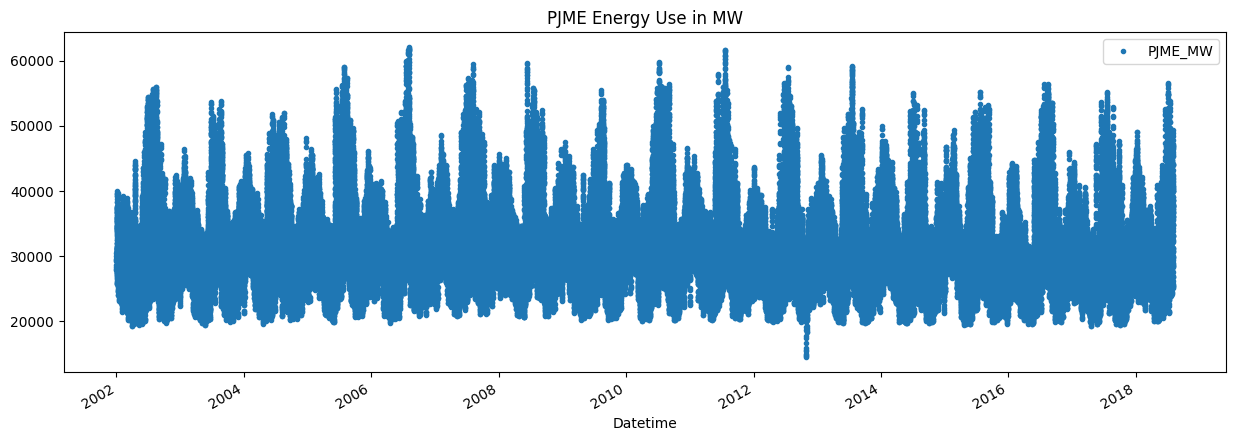

In [48]:
#Overview of Data
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

- We can see the outliers between 2012 to 2014 which are below 20000MW

<Axes: ylabel='Frequency'>

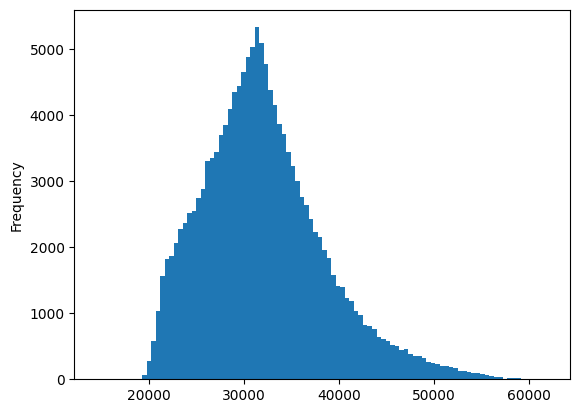

In [49]:
df['PJME_MW'].plot(kind='hist', bins=100)

In [50]:
#statistics of Engery
df['PJME_MW'].describe()

count    145366.000000
mean      32080.222831
std        6464.012166
min       14544.000000
25%       27573.000000
50%       31421.000000
75%       35650.000000
max       62009.000000
Name: PJME_MW, dtype: float64

<Axes: title={'center': 'Outliers below 20000'}, xlabel='Datetime'>

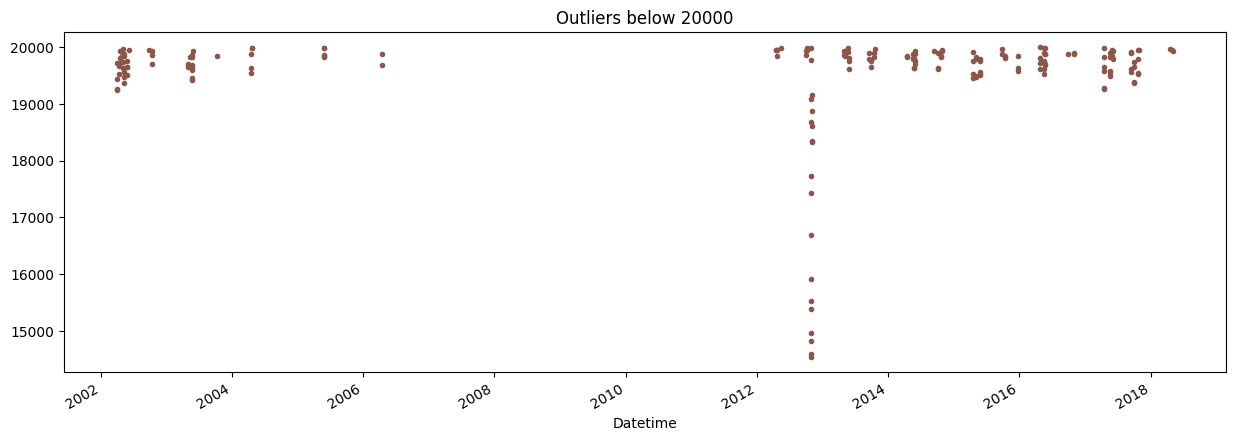

In [51]:
#Outliers below 20000MW
df.query('PJME_MW < 20_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers below 20000')

<Axes: title={'center': 'Outliers below 19000'}, xlabel='Datetime'>

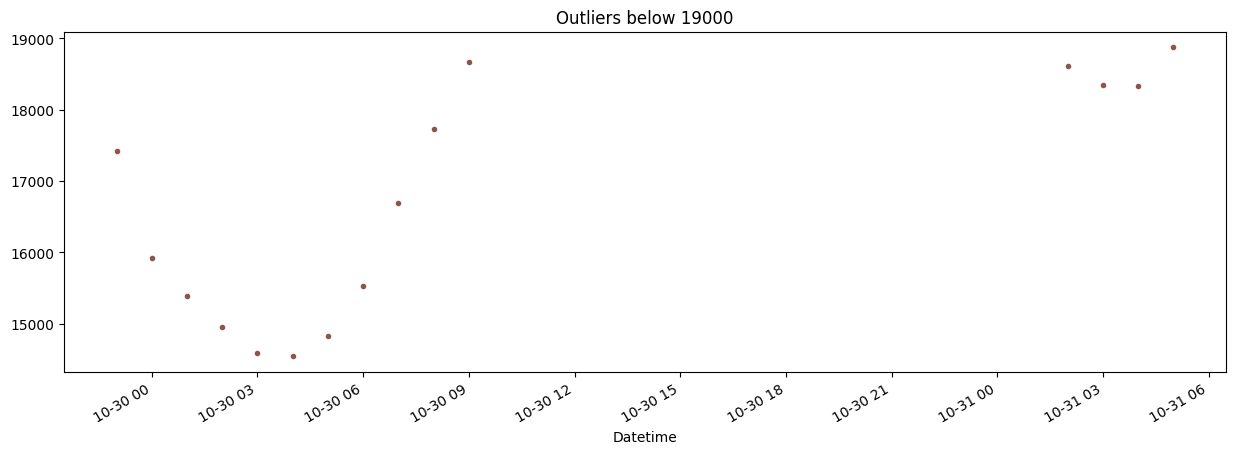

In [52]:
#Outliers below 19000MW
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers below 19000')

In [53]:
#dropping the values below 19000 MW
df = df.query('PJME_MW > 19_000').copy()

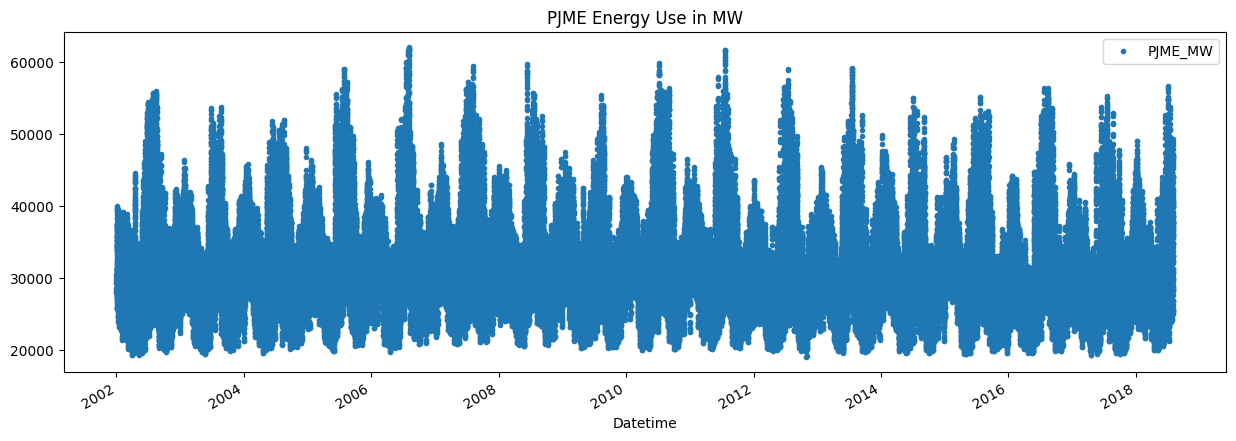

In [54]:
#Energy Usage after droping outliers
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

In [56]:
#Create time series features based on time series index.
def create_features(df):

    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

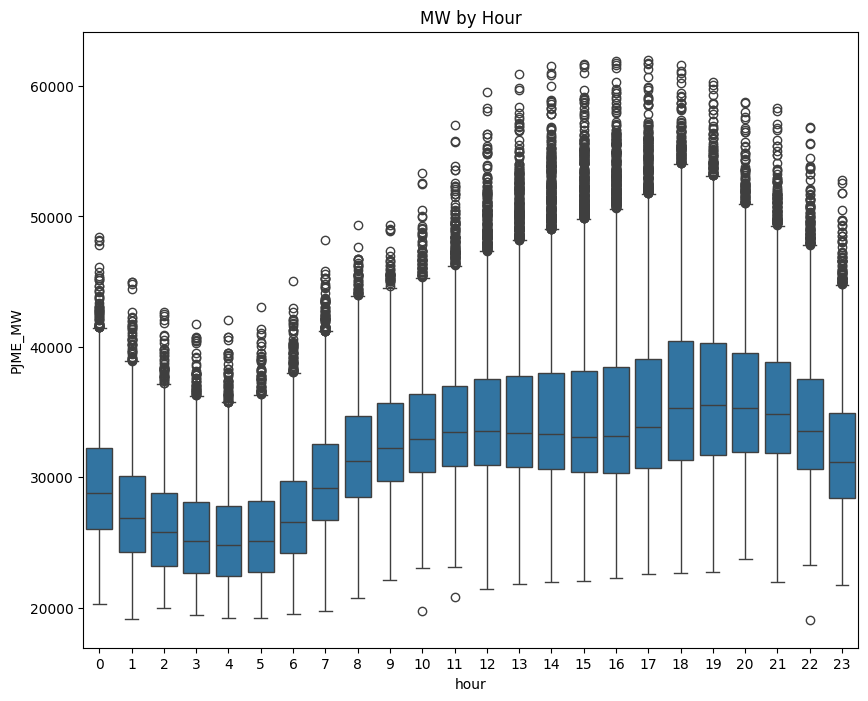

In [57]:
#Hourly consumption
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

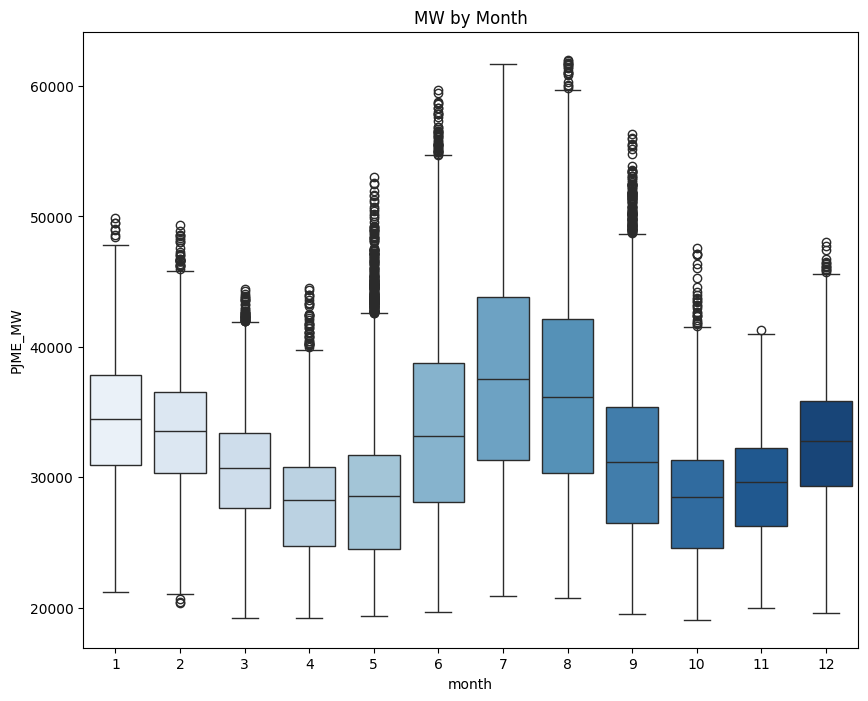

In [58]:
#Monthly consumption
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

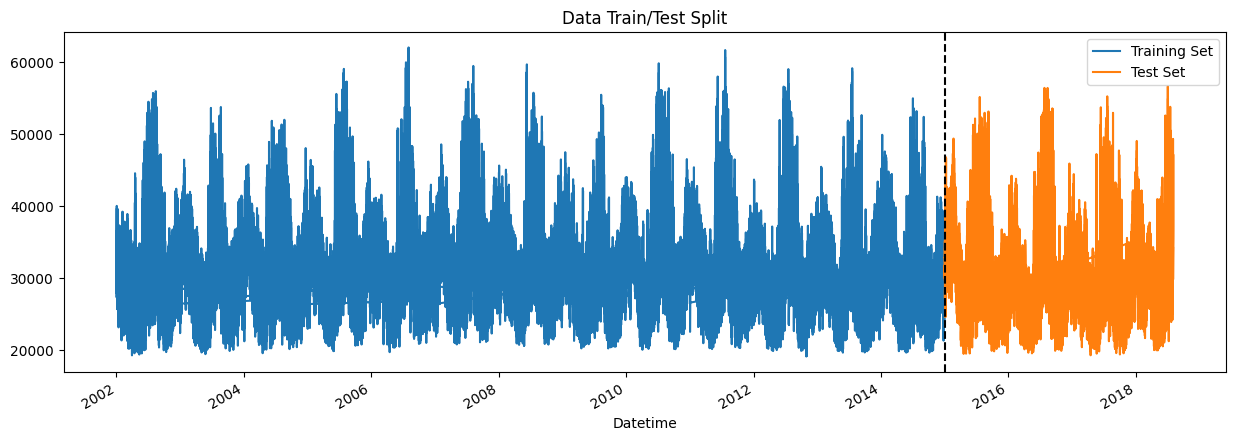

In [55]:
# Split the data
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()


### Time Series Cross Validation

In [59]:
#splitting for cross-validation using Timeseries split
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

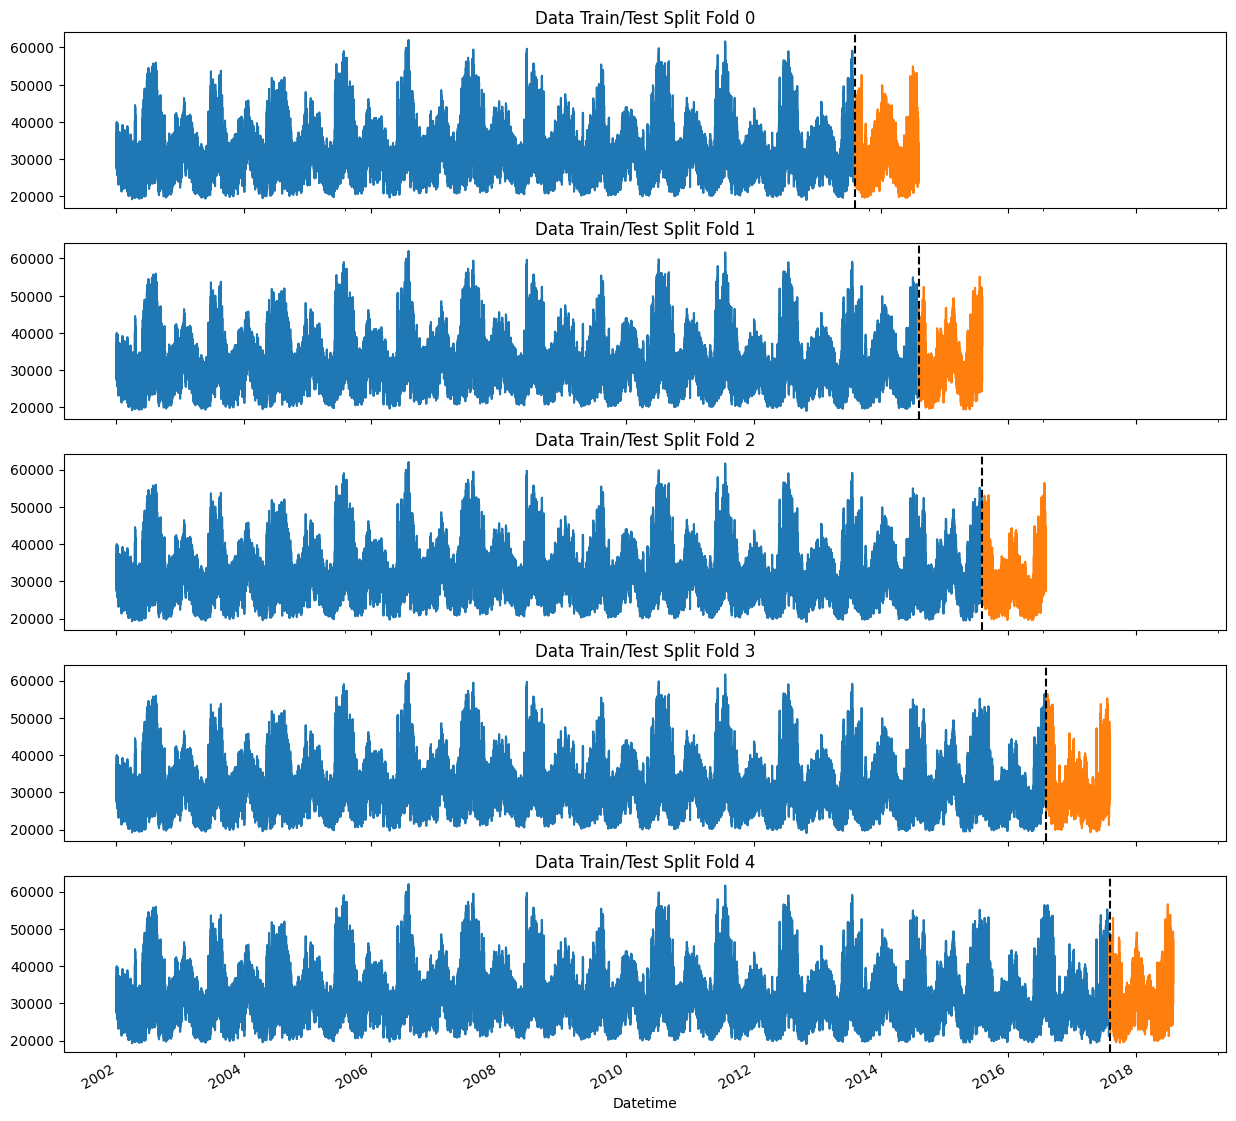

In [60]:
# representation of Train-test split for cross validation
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

### Feature Engineering: Creating 1-Year, 2-Year, and 3-Year Lag Features

In [61]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [62]:
df = add_lags(df)

In [63]:
#train the model using cross validation
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163
[100]	validation_0-rmse:12532.64369	validation_1-rmse:11906.14134
[200]	validation_0-rmse:5747.92495	validation_1-rmse:5359.26490
[300]	validation_0-rmse:3872.48134	validation_1-rmse:3900.86965
[400]	validation_0-rmse:3434.23853	validation_1-rmse:3762.33705
[442]	validation_0-rmse:3369.34730	validation_1-rmse:3764.82810
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32138.89241
[100]	validation_0-rmse:12513.65574	validation_1-rmse:12224.93373
[200]	validation_0-rmse:5753.34937	validation_1-rmse:5662.07107
[300]	validation_0-rmse:3902.71304	validation_1-rmse:3933.73076
[400]	validation_0-rmse:3476.90515	validation_1-rmse:3590.55005
[500]	validation_0-rmse:3353.72424	validation_1-rmse:3516.39915
[600]	validation_0-rmse:3297.94766	validation_1-rmse:3481.94003
[700]	validation_0-rmse:3258.48267	validation_1-rmse:3461.37383
[800]	validation_0-rmse:3221.51553	validation_1-rmse:3436.49603
[900]	validation_0-rmse:3190.11480	v

In [64]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3742.5833
Fold scores:[3760.8277187583353, 3420.313091887879, 3478.018038580526, 4052.5712055405547, 4001.186553933809]


In [81]:
#predicting the future

df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1', 'lag2', 'lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

# Use 'reg:squarederror' as the objective
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=550,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)


[0]	validation_0-rmse:32403.88991
[100]	validation_0-rmse:12426.83220
[200]	validation_0-rmse:5751.73275
[300]	validation_0-rmse:3971.53256
[400]	validation_0-rmse:3571.21833
[500]	validation_0-rmse:3456.23244
[549]	validation_0-rmse:3426.40525


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=550, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [76]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [77]:
future_w_features = df_and_future.query('isFuture').copy()

In [78]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

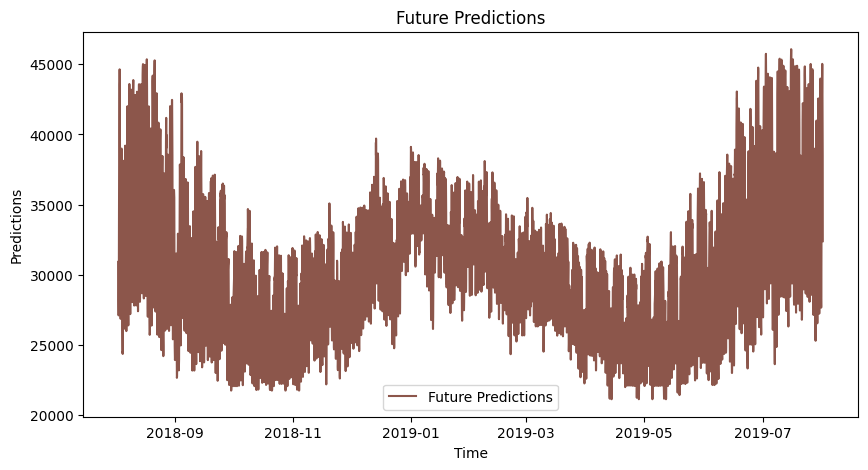

In [85]:
import matplotlib.pyplot as plt

# Create a plot
plt.figure(figsize=(10, 5))

# Plot the predictions
plt.plot(future_w_features['pred'],
         color=color_pal[5],
         label='Future Predictions')


plt.title('Future Predictions')
plt.xlabel('Time')
plt.ylabel('Predictions')
plt.legend()
plt.show()